In [1]:
import json
import configuration as config
from data_loader.base_dataset import BaseDataset
from models.nrha_title import NRHATitle
from models.nrha_body import NRHABody


In [2]:
# define some variables here
from utils.helpers import Converter
mind_type = "large"

In [3]:
def load_news(news_path):
    news = {"title": [""], "category": [""], "subcategory": [""], "abstract": [""], "entity": [""]}
    with open(news_path, "r", encoding="utf-8") as rd:
        for index in rd:
            # news id, category, subcategory, title, abstract, url
            nid, vert, subvert, title, ab, url, entity, _ = index.strip("\n").split("\t")
            current = {"title": title, "category": vert, "subcategory": subvert, "abstract": ab, "entity": entity}
            for k, v in news.items():
                v.append(current[k])
    return news

In [4]:
config.set_data_root_path(json.load(open("../config.json"))["data_root_path"])
hparams = config.get_params("../config/nrha_body.yaml", head_num=10, head_dim=30)

In [6]:
news_file, behaviors_file = config.get_path("train", mind_type=mind_type)
converter = Converter(hparams).converter
dataset = BaseDataset(news_file, behaviors_file, hparams, converter)

In [7]:
news_ori_info = load_news(news_file)
news_title = dataset.news_matrix["title_index"]
news_body = dataset.news_matrix["body_index"]
titles_words = dataset.news["title"]
body_words = dataset.body

In [8]:
import torch
# load model
device = torch.device("cuda")
best_model_path = f"checkpoint/nrha_body/best_model.ckpt"
model = NRHABody(hparams).load_from_checkpoint(best_model_path, hparams=hparams).to(device)

In [9]:
import numpy as np

def sentence_encoder(x_embedding):
    # get head representation
    y = model.news_encode_layer(x_embedding)
    # head attention
    y = y.view(y.shape[0], y.shape[1], hparams.head_num, -1)
    # shape of y: [N, S, H, D]     E is head_num * head_dim, E = H * D
    y = y.transpose(1, 2).transpose(0, 1)
    # shape of y: [H, N, S, D]
    output, weights = [], []
    for h, attention in zip(y, model.news_attentions):
        out, weight = attention(h)
        output.append(out)
        weights.append(weight)
    weights = torch.stack(weights)
    output = torch.stack(output).squeeze().transpose(0, 1)
    # output = output.reshape(output.shape[0], -1)
    weights = torch.squeeze(weights.transpose(0, 1))
    weights = weights.cpu().detach().numpy()
    return output, weights

def run_model(start, end):
    # get embedding output
    x_title = torch.tensor(news_title[start:end], dtype=torch.long).to(device)
    x_body = torch.tensor(news_body[start:end], dtype=torch.long).to(device)
    title_embedding = model.embedding_layer(x_title)
    title, t_weights = sentence_encoder(title_embedding)
    x_body = model.embedding_layer(x_body)
    x_body = x_body.reshape(x_body.shape[0], hparams.body_shape[0], hparams.body_shape[1], hparams.word_emb_dim)
    body = x_body.transpose(0, 1)
    q = title.reshape(title.shape[0] * hparams.head_num, 1, hparams.head_dim)
    y, b_weights = [], []
    for sent in body:
        y_body, b_weight = sentence_encoder(sent)
        y.append(y_body)
        b_weights.append(b_weight)
    y = torch.stack(y).transpose(0, 1)
    b_weights = np.array(b_weights).transpose((1, 0, 2, 3))
    # y = y.reshape(-1, hparams.body_shape[0], hparams.head_num, hparams.head_dim)
    y = y.reshape(y.shape[0] * hparams.head_num, hparams.body_shape[0], hparams.head_dim)
    y, s_weights = model.title_body_att(q, y)
    s_weights = s_weights.reshape(-1, hparams.head_num, hparams.body_shape[0]).cpu().detach().numpy()
    return t_weights, b_weights, s_weights

t_w, b_w, s_w = run_model(1, 10)

In [16]:
from colr import color
head_colors = [c for c in range(1, 11)]
head_colors.extend([15, 19, 21, 37, 70, 82, 87, 148, 159, 190, 249])

def get_weighed_words(weights, words_list, threshold=None):
    threshold = threshold or np.mean(np.max(weights, axis=-1))
    heads_words = {i: [] for i in range(hparams.head_num)}
    for i in range(min(len(words_list), len(weights))):
        hit_words = {}
        words = words_list[i]
        # loop head weight: j from 0 to head_num-1
        for h, head_w in enumerate(weights[i]):
            for k, word_w in enumerate(head_w):
                if word_w > threshold:
                    if k not in range(len(words)): continue
                    # heads_words[h].append(words[k])
                    hit_words[k] = (h, word_w) if k not in hit_words or word_w > hit_words[k][1] else hit_words[k]
        for k in hit_words.keys():
            if hit_words[k][0] not in heads_words or k not in range(len(words)):
                print(hit_words[k][0], k)
                continue
            heads_words[hit_words[k][0]].append(words[k])
        # print(f"Original Sentence:\n{sent}")
        weighted_sent = " ".join([color(word, back=head_colors[hit_words[w][0]]) if w in hit_words else word
                                  for w, word in enumerate(words)])
        print(f"Weighted Sentence:\n{weighted_sent}")
    return heads_words

def print_words(start, end, threshold=None):
    t_weights, b_weights, s_weights = run_model(start, end)
    threshold = threshold or np.mean(np.max(t_weights, axis=-1))
    heads_words = {i: [] for i in range(hparams.head_num)}
    for h, words in get_weighed_words(t_weights, titles_words[start:], threshold).items():
        heads_words[h].extend(words)
    b_heads = [get_weighed_words(weights, body_words[start+i], threshold) for i, weights in enumerate(b_weights)]
    for head_w in b_heads:
        [heads_words[h].extend(words) for h, words in head_w.items()]
    print(heads_words)
    return heads_words, s_weights

In [17]:
start_index, step = 1, 10

In [18]:
ws, sw = print_words(start_index, start_index + step, 0.2)
start_index += step

Weighted Sentence:
the brands queen elizabeth , prince charles , and prince philip swear by
Weighted Sentence:
walmart slashes prices on last generation ipads
Weighted Sentence:
50 worst habits for belly fat
Weighted Sentence:
dispose of unwanted prescription drugs during the dea s take back day
Weighted Sentence:
the cost of trump s aid freeze in the trenches of ukraine s war
Weighted Sentence:
i was an nba wife . here s how it affected my mental health .
Weighted Sentence:
how to get rid of skin tags , according to a dermatologist
Weighted Sentence:
check houston traffic map for current road conditions
Weighted Sentence:
should nfl be able to fine players for criticizing officiating ?
Weighted Sentence:
how to record your screen on windows , macos , ios or android
Weighted Sentence:
the royals are free to shop wherever they choose , but they tend to keep it in the family the royal warrant family , that is .
Weighted Sentence:
this year , walmart s not waiting until to offer steep dea

In [12]:
head_words = {h: [] for h in range(hparams.head_num)}
sent_weights = []
for index in range(0, len(news_title), 256):
    end_index = min(len(news_title), index + 256)
    if index >= end_index-1: continue
    hw, sw = print_words(index, min(len(dataset), index + 256))
    sent_weights.extend(sw)
    for h, ws in hw.items():
        head_words[h].extend(ws)

In [13]:
from collections import Counter
head_words_freq = {}
for h, ws in head_words.items():
    if not ws: continue
    head_words_freq[h] = Counter(ws)

In [14]:
convert_text = """
1.      CC      Coordinating conjunction
2.     CD     Cardinal number
3.     DT     Determiner
4.     EX     Existential there
5.     FW     Foreign word
6.     IN     Preposition or subordinating conjunction
7.     JJ     Adjective
8.     JJR     Adjective, comparative
9.     JJS     Adjective, superlative
10.     LS     List item marker
11.     MD     Modal
12.     NN     Noun, singular or mass
13.     NNS     Noun, plural
14.     NNP     Proper noun, singular
15.     NNPS     Proper noun, plural
16.     PDT     Predeterminer
17.     POS     Possessive ending
18.     PRP     Personal pronoun
19.     PRP$     Possessive pronoun
20.     RB     Adverb
21.     RBR     Adverb, comparative
22.     RBS     Adverb, superlative
23.     RP     Particle
24.     SYM     Symbol
25.     TO     to
26.     UH     Interjection
27.     VB     Verb, base form
28.     VBD     Verb, past tense
29.     VBG     Verb, gerund or present participle
30.     VBN     Verb, past participle
31.     VBP     Verb, non-3rd person singular present
32.     VBZ     Verb, 3rd person singular present
33.     WDT     Wh-determiner
34.     WP     Wh-pronoun
35.     WP$     Possessive wh-pronoun
36.     WRB     Wh-adverb """
convert_text = convert_text.split("\n")
convert_dic = {}
for text in convert_text[1:]:
    text = text.split()
    convert_dic[text[1]] = " ".join(text[2:])

In [15]:
import nltk
from nltk.corpus import stopwords
head_words_freq_ns = {}
head_tagged = {}
stops = list(set(stopwords.words("english")))
english_punctuations = [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%']
for h, ws_freq in head_words_freq.items():
    head_words_freq_ns[h] = {w: freq for w, freq in ws_freq.items() if w not in stops + english_punctuations}
    tagged = nltk.pos_tag(head_words_freq_ns[h].keys())
    head_tagged[h] = {}
    for word, tag in tagged:
        tag = convert_dic[tag] if tag in convert_dic else "?"
        if tag not in head_tagged[h]:
            head_tagged[h][tag] = []
        head_tagged[h][tag].append(word)

In [16]:
for h, tagged in head_tagged.items():
    print(f"Head {h}")
    sort = sorted(tagged.items(),key=lambda e:len(e[1]),reverse=True)
    for tag, ws in sort:
        print(f"Tag '{tag}' include {len(ws)} words: {''.join([f'{w}({head_words_freq[h][w]})' for w in ws])}")

Head 0
Tag 'Noun, singular or mass' include 245 words: walmart(21)freeze(115)grocery(169)listeria(40)pizza(283)coffee(303)salt(40)seafood(298)food(1106)meal(337)appetizer(43)dish(428)chile(60)ground(4)drizzle(8)mold(76)evacuation(538)grandmother(6)infestation(3)barbecue(105)grease(32)bacon(149)menu(67)pizzas(107)filet(8)mph(62)cleanup(8)tornado(312)typhoon(50)gluten(24)fridge(80)bakery(118)dishwasher(389)chili(87)explosion(148)cookware(26)savory(37)pie(23)planet(119)carb(24)boil(49)cooker(44)altitude(23)fedex(94)tomato(3)onion(41)scam(25)tacos(64)cookbook(49)refrigerator(46)medication(31)brisket(51)taco(27)butter(52)diner(148)earthquake(277)disaster(32)breakfast(59)wreck(13)cookbooks(15)delivery(36)dust(22)smokehouse(3)pepperoni(19)pumpkin(87)rice(100)salmon(68)cheddar(10)doughnut(16)pepper(58)cabbage(21)mozzarella(24)nutrition(6)chernobyl(1)homemade(112)cinnamon(27)bedbugs(3)vacuum(12)cod(96)pcos(1)psoriasis(9)salmonella(18)pastry(28)cookout(2)flu(16)survivor(1)clam(18)pill(49)tuna(14

In [17]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
w = wordcloud.WordCloud(width=1000, height=700, background_color='white', stopwords=STOPWORDS, font_path='msyh.ttc')

[('died', 1554), ('easy', 1414), ('food', 1106), ('recipe', 961), ('cook', 954), ('recipes', 762), ('fish', 583), ('overnight', 569), ('evacuation', 538), ('dishes', 484)]
[('defensive', 1647), ('cornerback', 546), ('coordinator', 476), ('interception', 452), ('fumble', 381), ('yards', 320), ('linebacker', 308), ('drone', 299), ('coroner', 215), ('redshirt', 181)]
[('record', 3419), ('safety', 3213), ('points', 3129), ('car', 2936), ('scored', 2700), ('fort', 2336), ('board', 2270), ('crash', 2240), ('added', 2225), ('check', 2087)]
[('.', 3767), ('is', 2355), ('and', 2063), ('said', 2040), (',', 1965), ('!', 1861), ('?', 1785), ('the', 1708), ('it', 1630), ('he', 1575)]
[('dog', 3013), ('story', 2847), ('missing', 2814), ('found', 2760), ('dogs', 1903), ('dead', 1725), ('bears', 1722), ('taken', 1655), ('fox', 1545), ('yelp', 1511)]
[('number', 982), ('track', 746), ('road', 736), ('spots', 528), ('outages', 483), ('runs', 475), ('heights', 467), ('pole', 441), ('bike', 438), ('rental

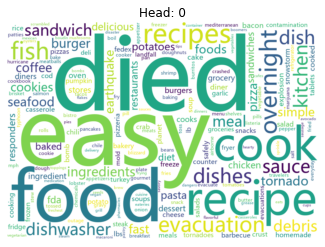

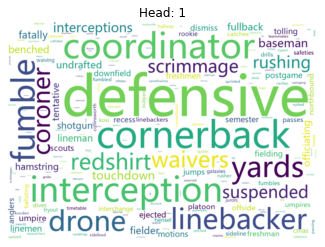

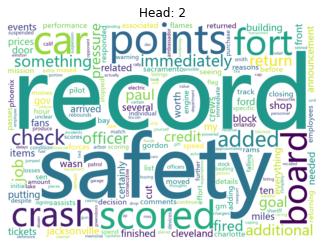

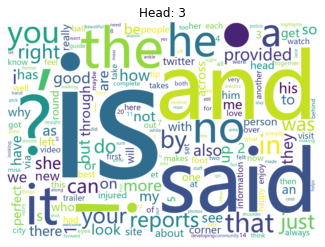

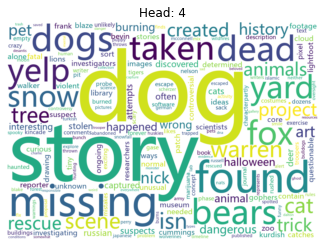

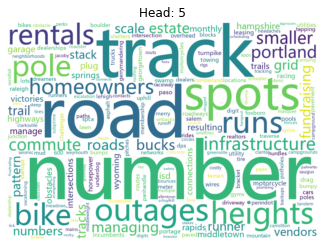

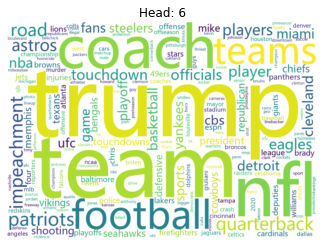

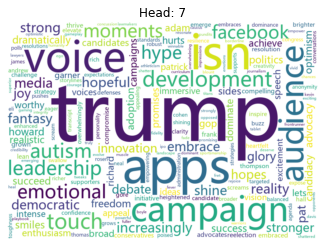

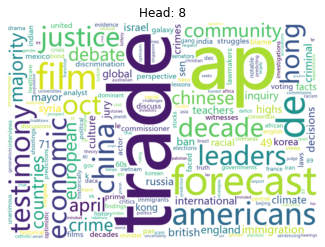

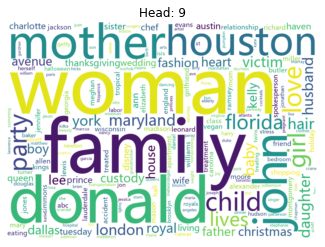

In [18]:
for h, ws_freq in head_words_freq.items():
    sort = sorted(ws_freq.items(),key=lambda e:e[1],reverse=True)
    print(sort[:10])
    w.generate_from_frequencies(ws_freq)
    plt.axis("off")
    plt.title(f"Head: {h}")
    plt.imshow(w, interpolation='bilinear')
    plt.show()

[('died', 1554), ('easy', 1414), ('food', 1106), ('recipe', 961), ('cook', 954), ('recipes', 762), ('fish', 583), ('overnight', 569), ('evacuation', 538), ('dishes', 484)]
[('defensive', 1647), ('cornerback', 546), ('coordinator', 476), ('interception', 452), ('fumble', 381), ('yards', 320), ('linebacker', 308), ('drone', 299), ('coroner', 215), ('redshirt', 181)]
[('record', 3419), ('safety', 3213), ('points', 3129), ('car', 2936), ('scored', 2700), ('fort', 2336), ('board', 2270), ('crash', 2240), ('added', 2225), ('check', 2087)]
[('said', 2040), ('reports', 681), ('right', 562), ('provided', 507), ('1', 504), ('also', 442), ('good', 418), ('look', 369), ('2', 319), ('see', 315)]
[('dog', 3013), ('story', 2847), ('missing', 2814), ('found', 2760), ('dogs', 1903), ('dead', 1725), ('bears', 1722), ('taken', 1655), ('fox', 1545), ('yelp', 1511)]
[('number', 982), ('track', 746), ('road', 736), ('spots', 528), ('outages', 483), ('runs', 475), ('heights', 467), ('pole', 441), ('bike', 43

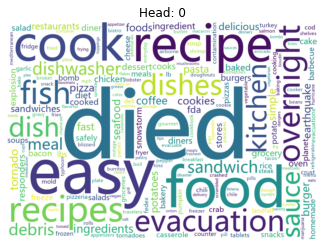

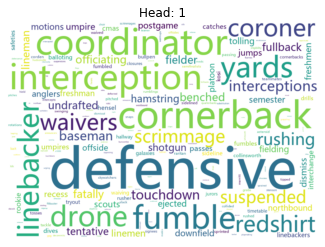

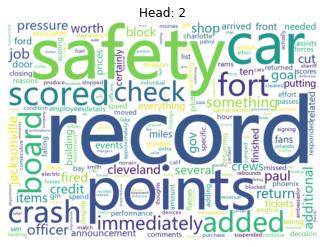

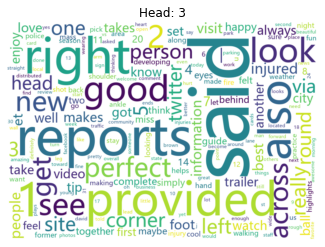

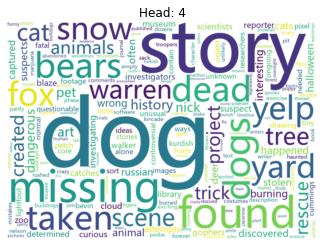

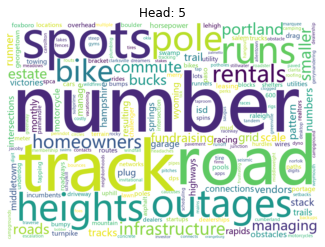

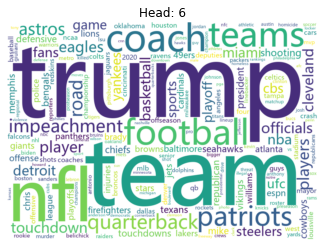

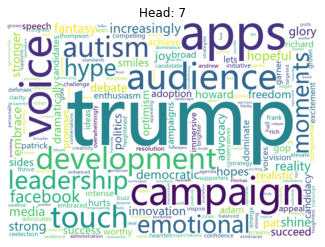

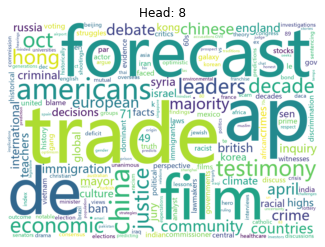

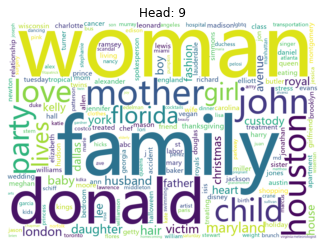

In [19]:
for h, ws_freq in head_words_freq_ns.items():
    sort = sorted(ws_freq.items(),key=lambda e:e[1],reverse=True)
    print(sort[:10])
    w.generate_from_frequencies(ws_freq)
    plt.axis("off")
    plt.title(f"Head: {h}")
    plt.imshow(w, interpolation='bilinear')
    plt.show()

In [20]:
import seaborn as sns
sns.set(font_scale=1.5)

In [21]:
import pandas as pd
news_df = pd.DataFrame(news_ori_info)

### Meaning of head(roughly):

- head 0: food, diet
- head 1: American football, athlete related
- head 2: record related, car accident
- head 3: reports, some number or action(verbs)
- head 4: animals related, such as dogs, bears, fox, yelp
- head 5: UNKNOWN
- head 6: NFL, football match related
- head 7: social media ?
- head 8: trade, economy related
- head 9: family related, some names such as Donald, John

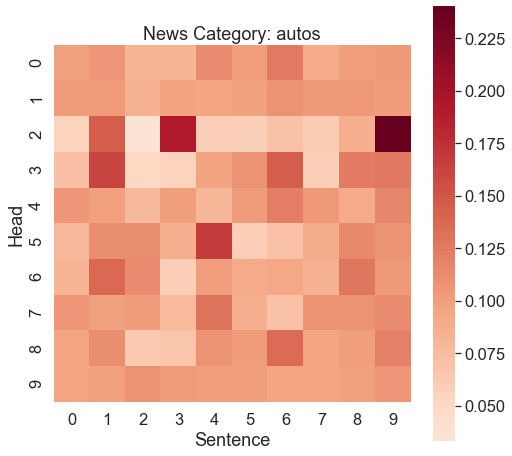

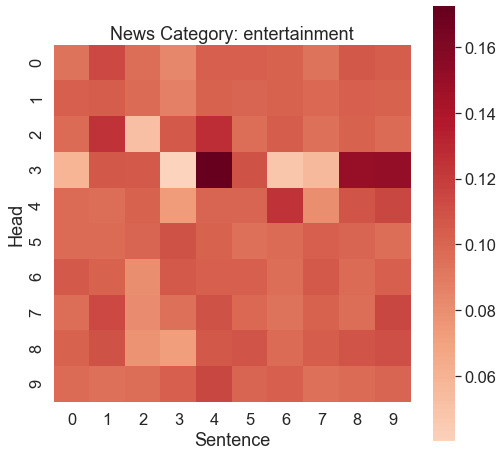

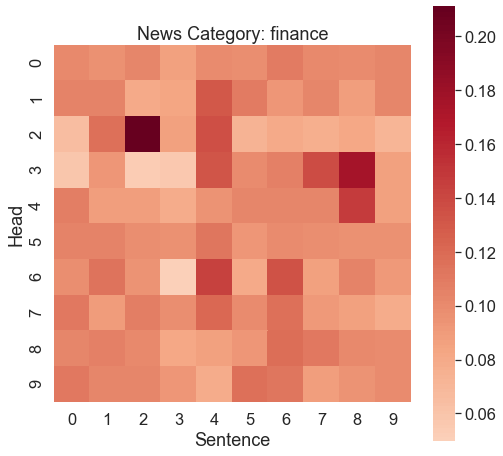

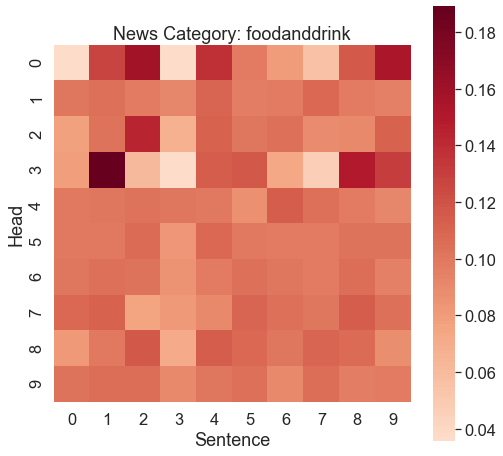

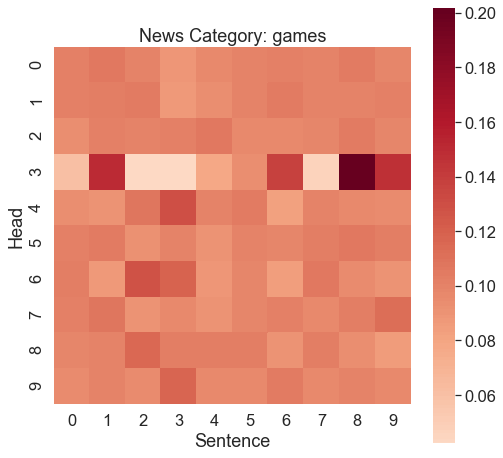

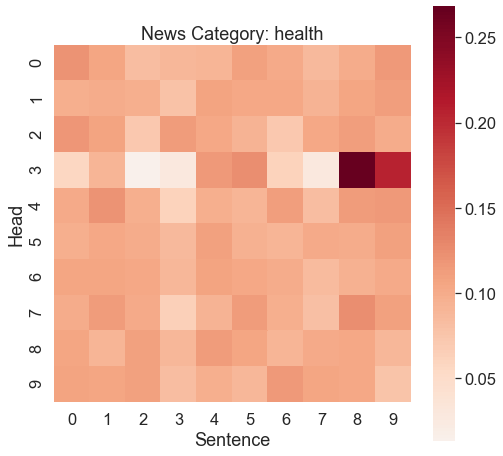

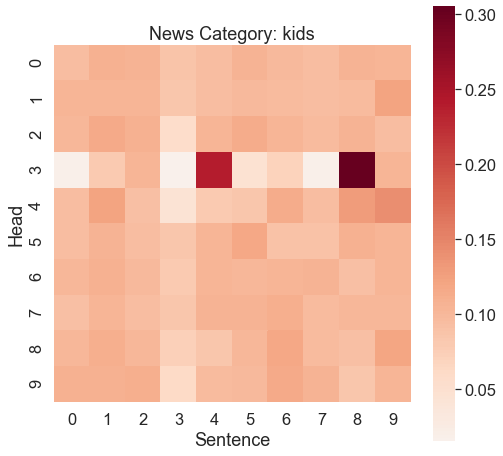

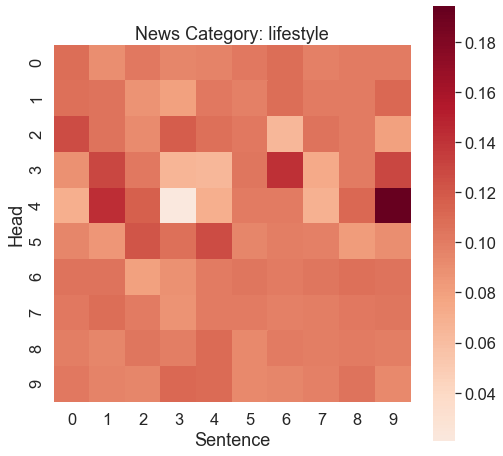

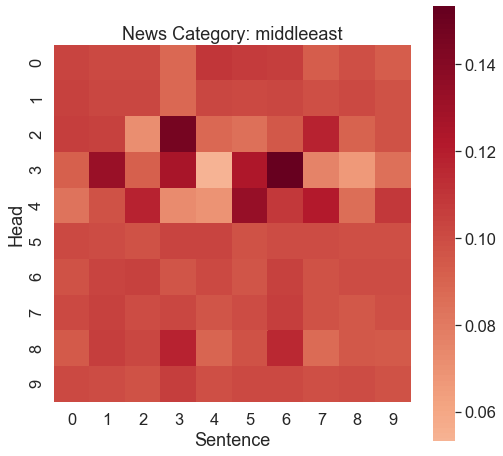

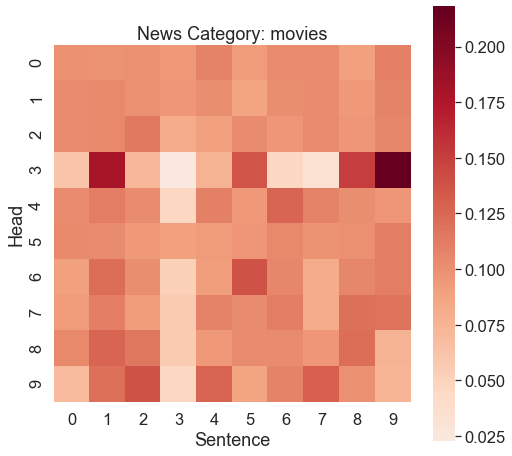

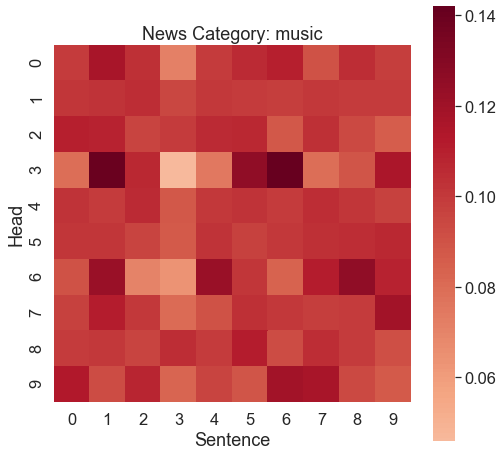

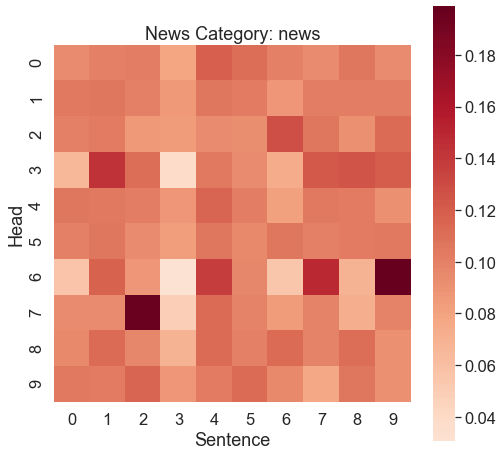

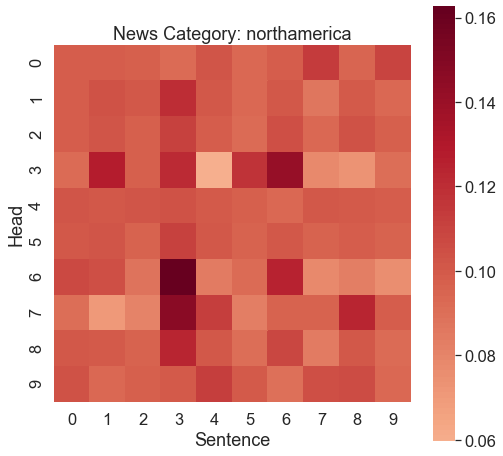

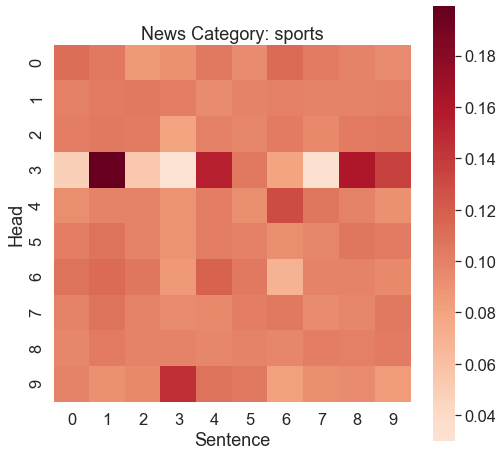

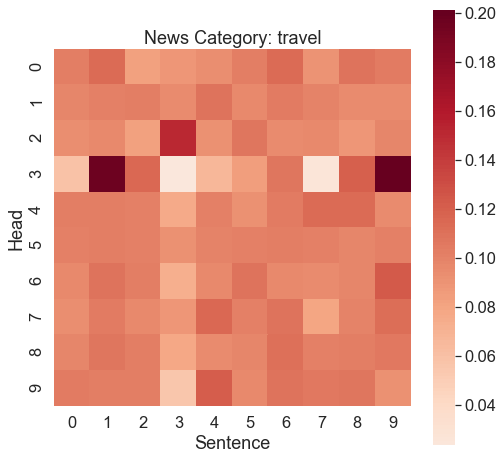

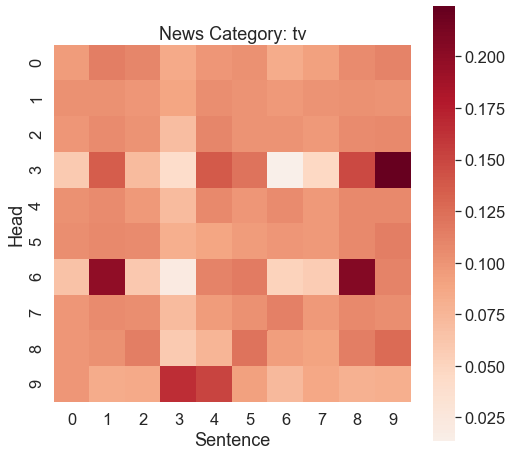

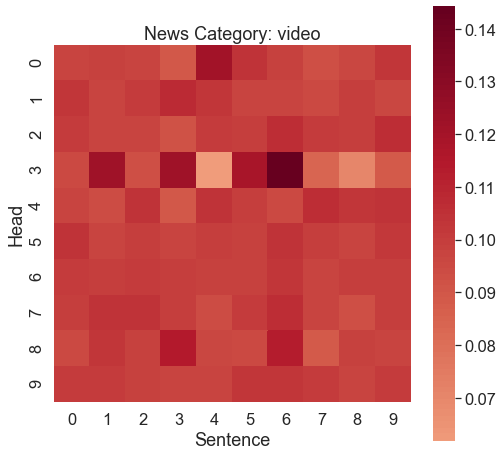

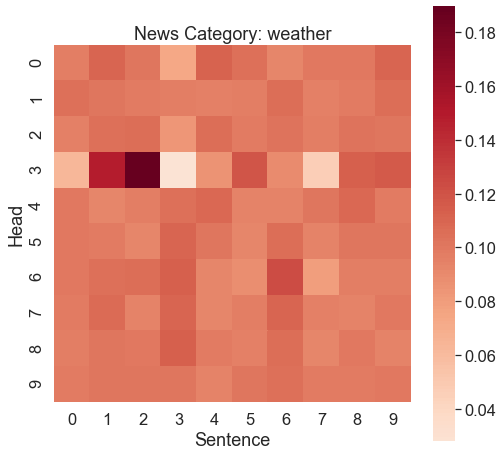

In [22]:
import matplotlib.pyplot as plot
for (category, group_df) in news_df.groupby(["category"]):
    if not category: continue
    # print(f"New Category: {category}")
    random_selected = np.random.randint(0, len(group_df), 1)
    random_index = group_df.index[random_selected][0]
    sns.set_context({"figure.figsize":(8,8)})
    sns.heatmap(data=sent_weights[random_index], square=True, cmap="RdBu_r", center=0)
    plot.title(f"News Category: {category}")
    plot.ylabel("Head")
    plot.xlabel("Sentence")
    plot.show()

